# 流程

|步骤|内容|关键技术/方法|
|-|-|-|
|问题定义|确定任务类型（分类、回归、聚类等）和业务目标|与领域专家协作，明确输入输出|
|数据预处理|清洗数据、处理缺失值、标准化/归一化|均值填充、插值法、Min-Max标准化|
|特征选择|筛选相关性强的特征，降维|方差选择法、卡方检验、PCA|
|模型选择|根据任务选择模型（如线性回归、决策树）|简单任务优先尝试经典模型|
|训练与评估|划分训练集/测试集，训练模型并评估性能	|交叉验证、准确率/精确率/召回率、ROC曲线|

> 某电信公司发现客户流失率逐年上升，需建立模型预测哪些客户可能流失，并分析潜在客户群体特征。数据包括客户基本信息、服务使用情况和历史流失标签（1=流失，0=未流失）。

[数据源](https://www.kaggle.com/datasets/blastchar/telco-customer-churn?resource=download)

# 目标：

- 预测客户是否可能流失
- 发现未标注数据中的客户群体特征


In [139]:
# 数据源加载
import kagglehub

# Download latest version
dataPath = kagglehub.dataset_download("blastchar/telco-customer-churn")

print("Path to dataset files:", dataPath)

Path to dataset files: /Users/HarowrdLiu/.cache/kagglehub/datasets/blastchar/telco-customer-churn/versions/1


# 问题定义

## 任务类型
- Q1 监督学习（使用带标签的数据集进行学习，学习输入特征和标签之间的关系）
- Q2 无监督学习 （客户群体细分，聚类任务）

## 输入输出
### Q1
输入：客户年龄、月费用、合约市场、故障报修次数、服务评分等。
输出：是否流失（0/1）

### Q2
输入：客户年龄、月费用、合约市场、故障报修次数、服务评分等。
输出：客户群体类别

# 数据预处理

In [140]:
import pandas as pd
import os

# 读取数据集
data_file = os.path.join(dataPath, 'WA_Fn-UseC_-Telco-Customer-Churn.csv')
df = pd.read_csv(data_file)

print("数据集基本信息:")
print(f"数据集形状: {df.shape}")
print(f"列数: {df.shape[1]}")
print(f"行数: {df.shape[0]}")
print("\n前5行数据:")
df.head()


数据集基本信息:
数据集形状: (7043, 21)
列数: 21
行数: 7043

前5行数据:


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 数据检查

In [141]:
import numpy as np

# 检查特殊值和隐式缺失值
print("=== 特殊值检查 ===")
print("\n1. 检查空字符串:")
for col in df.columns:
    if df[col].dtype == 'object':
        empty_count = (df[col] == '').sum()
        if empty_count > 0:
            print(f"   {col}: {empty_count} 个空字符串")

print("\n2. 检查空格字符串:")
for col in df.columns:
    if df[col].dtype == 'object':
        whitespace_count = (df[col].str.strip() == '').sum()
        if whitespace_count > 0:
            print(f"   {col}: {whitespace_count} 个空格字符串")

print("\n3. 检查特殊标记值 (如 'Unknown', 'N/A', 'None' 等):")
special_values = ['Unknown', 'N/A', 'None', 'unknown', 'n/a', 'none', 'NULL', 'null']
for col in df.columns:
    if df[col].dtype == 'object':
        for special_val in special_values:
            count = (df[col] == special_val).sum()
            if count > 0:
                print(f"   {col}: {count} 个 '{special_val}' 值")

print("\n4. 数值列统计信息:")
numeric_cols = df.select_dtypes(include=[np.number]).columns
if len(numeric_cols) > 0:
    print(df[numeric_cols].describe())
else:
    print("   没有数值列")

print("\n5. 字符串列唯一值统计:")
object_cols = df.select_dtypes(include=['object']).columns
for col in object_cols:
    unique_count = df[col].nunique()
    print(f"   {col}: {unique_count} 个唯一值")
    if unique_count <= 10:  # 如果唯一值不多，显示所有值
        print(f"      值: {df[col].unique()}")


=== 特殊值检查 ===

1. 检查空字符串:

2. 检查空格字符串:
   TotalCharges: 11 个空格字符串

3. 检查特殊标记值 (如 'Unknown', 'N/A', 'None' 等):

4. 数值列统计信息:
       SeniorCitizen       tenure  MonthlyCharges
count    7043.000000  7043.000000     7043.000000
mean        0.162147    32.371149       64.761692
std         0.368612    24.559481       30.090047
min         0.000000     0.000000       18.250000
25%         0.000000     9.000000       35.500000
50%         0.000000    29.000000       70.350000
75%         0.000000    55.000000       89.850000
max         1.000000    72.000000      118.750000

5. 字符串列唯一值统计:
   customerID: 7043 个唯一值
   gender: 2 个唯一值
      值: ['Female' 'Male']
   Partner: 2 个唯一值
      值: ['Yes' 'No']
   Dependents: 2 个唯一值
      值: ['No' 'Yes']
   PhoneService: 2 个唯一值
      值: ['No' 'Yes']
   MultipleLines: 3 个唯一值
      值: ['No phone service' 'No' 'Yes']
   InternetService: 3 个唯一值
      值: ['DSL' 'Fiber optic' 'No']
   OnlineSecurity: 3 个唯一值
      值: ['No' 'Yes' 'No internet service']
   OnlineBac

In [142]:
df["TotalCharges"] = df["TotalCharges"].replace(" ", 0).astype(float)

## 编码分类变量
1. 根据分类变量转换成数字 （直接分类）
2. 对多分类进行独热编码 （多分类）

> 将数据降维，从高维语法降维为低维度数据。
> 机器学习模型（如线性回归、决策树）只能处理数值输入，无法直接处理文本标签。因此需要将分类变量转换为数值形式。

In [143]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
# 将二分类变量转换成数字
df["gender"] = le.fit_transform(df["gender"])
df["Partner"] = le.fit_transform(df["Partner"])
df["Dependents"] = le.fit_transform(df["Dependents"])
df["PhoneService"] = le.fit_transform(df["PhoneService"])
df["MultipleLines"] = le.fit_transform(df["MultipleLines"])
df["InternetService"] = le.fit_transform(df["InternetService"])
df["OnlineSecurity"] = le.fit_transform(df["OnlineSecurity"])
df["OnlineBackup"] = le.fit_transform(df["OnlineBackup"])
df["DeviceProtection"] = le.fit_transform(df["DeviceProtection"])
df["TechSupport"] = le.fit_transform(df["TechSupport"])
df["StreamingTV"] = le.fit_transform(df["StreamingTV"])
df["StreamingMovies"] = le.fit_transform(df["StreamingMovies"])
df["PaperlessBilling"] = le.fit_transform(df["PaperlessBilling"])
df["Churn"] = le.fit_transform(df["Churn"])

# 对多分类进行独热编码
df = pd.get_dummies(df, columns=["Contract", "PaymentMethod", ], dtype=float)

# 查看数据集
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,MonthlyCharges,TotalCharges,Churn,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,7590-VHVEG,0,0,1,0,1,0,1,0,0,...,29.85,29.85,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,5575-GNVDE,1,0,0,0,34,1,0,0,2,...,56.95,1889.50,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,3668-QPYBK,1,0,0,0,2,1,0,0,2,...,53.85,108.15,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,7795-CFOCW,1,0,0,0,45,0,1,0,2,...,42.30,1840.75,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,9237-HQITU,0,0,0,0,2,1,0,1,0,...,70.70,151.65,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0


## 标准化数值
标准化的核心目的是让不同尺度的特征具有可比性，避免某些特征因数值大而主导模型的训练和预测过程。

### 量纲差异
- 如果一个特征的范围是 0-1（如性别编码为 0/1），另一个特征范围是 0-1000（如年收入），模型会错误地认为后者更重要。
- 标准化后，所有特征处于同一数量级。
### 加速模型训练
- 梯度下降类模型（如逻辑回归、神经网络）在标准化后会更快收敛。
- 距离计算类模型（如K近邻、SVM）会更准确，因为它们依赖特征之间的距离。
### 避免数值问题
- 大数值可能导致计算时溢出（overflow），标准化后数值更稳定。

### 标准化和归一化
都是为了同一个目标，但是数学计算手段有差异。针对不同类型数据或模型选择不同的计算方式

- 标准化：如果原始数据有离群值（outliers），标准化后的值可能超出[-3,3]范围。
- 归一化：强制将所有值压缩到[0,1]，但受离群值影响更大。


| 方法          | 公式                          | 输出范围     | 适用场景                     |
|---------------|-------------------------------|--------------|------------------------------|
| **标准化**    | $ z = \frac{x - \mu}{\sigma} $ | 均值=0，标准差=1 | 高斯分布数据、大多数模型     |
| **归一化**    | $ x' = \frac{x - \min}{\max - \min} $ | [0,1]        | 图像处理（像素值0-255）、稀疏数据 |



In [144]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()  # 创建标准化器对象
df[["MonthlyCharges", "TotalCharges"]] = scaler.fit_transform(df[["MonthlyCharges", "TotalCharges"]])

df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,MonthlyCharges,TotalCharges,Churn,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,7590-VHVEG,0,0,1,0,1,0,1,0,0,...,-1.160323,-0.992611,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,5575-GNVDE,1,0,0,0,34,1,0,0,2,...,-0.259629,-0.172165,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,3668-QPYBK,1,0,0,0,2,1,0,0,2,...,-0.362660,-0.958066,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,7795-CFOCW,1,0,0,0,45,0,1,0,2,...,-0.746535,-0.193672,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,9237-HQITU,0,0,0,0,2,1,0,1,0,...,0.197365,-0.938874,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0


# 特征选择
## 本数据集演示

### 手动剔除（基于电信客户流失数据集）
- customerID 与目标变量无关，直接删除

In [145]:
df.drop(columns=["customerID"], inplace=True)

### 基于相关性分析

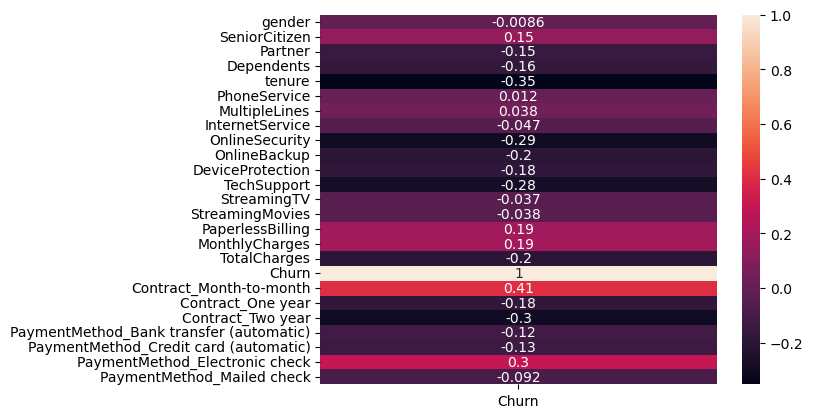

In [146]:
import seaborn as sns
import matplotlib.pyplot as plt

# 计算特征与目标的相关性
corr = df.corr()
sns.heatmap(corr[["Churn"]], annot=True)
plt.show()

#### 剔除与 Churn 相关系数绝对值小于 0.1 的特征

In [147]:
df.drop(columns=["gender", "PhoneService", "MultipleLines", "InternetService", "StreamingTV", "StreamingMovies", "PaymentMethod_Mailed check"], inplace=True)

df.head()

,SeniorCitizen,Partner,Dependents,tenure,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check
0,0,1,0,1,0,2,0,0,1,-1.160323,-0.992611,0,1.0,0.0,0.0,0.0,0.0,1.0
1,0,0,0,34,2,0,2,0,0,-0.259629,-0.172165,0,0.0,1.0,0.0,0.0,0.0,0.0
2,0,0,0,2,2,2,0,0,1,-0.362660,-0.958066,1,1.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,45,2,0,2,2,0,-0.746535,-0.193672,0,0.0,1.0,0.0,1.0,0.0,0.0
4,0,0,0,2,0,0,0,0,1,0.197365,-0.938874,1,1.0,0.0,0.0,0.0,0.0,1.0


### 处理多重共线性
- 检查特征间的相关性，剔除高度相关的特征，只保留一个。（多个高度相关的特征，理论上会加重这一特征的权重）

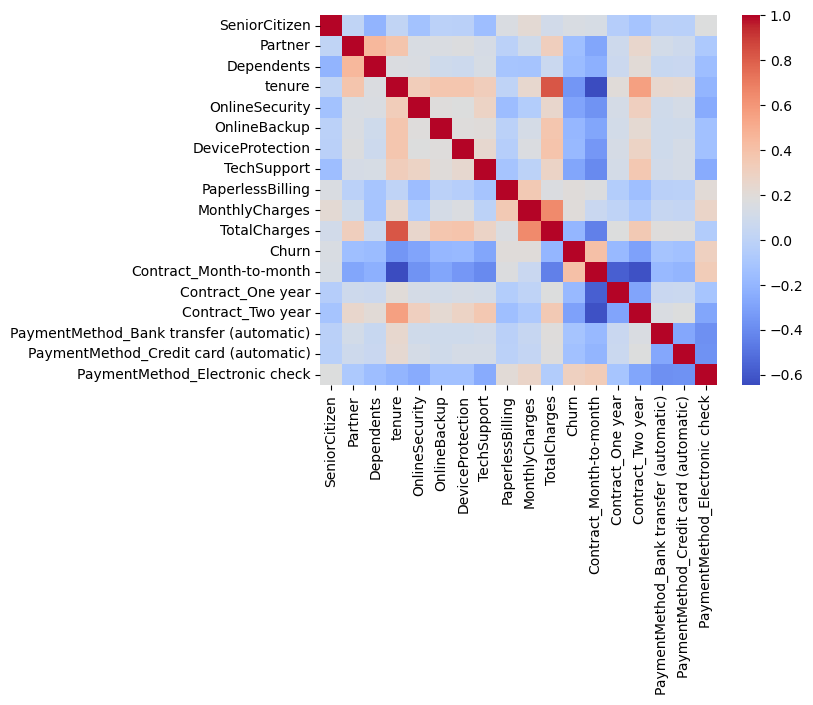

In [148]:
sns.heatmap(df.corr(), cmap="coolwarm")
plt.show()

#### tenure 和 totalCharges 高度正相关
- 保留 二者中的一个

> 还有很多进阶的类似检测方式 例如：VIF（方差膨胀因子）


### 基于特征重要性剔除
- 使用决策树或随机森林模型评估特征重要性，剔除低重要性特征，评估方式涉及到模型使用。
- 根据重要性进一步决定是否剔除某些特征

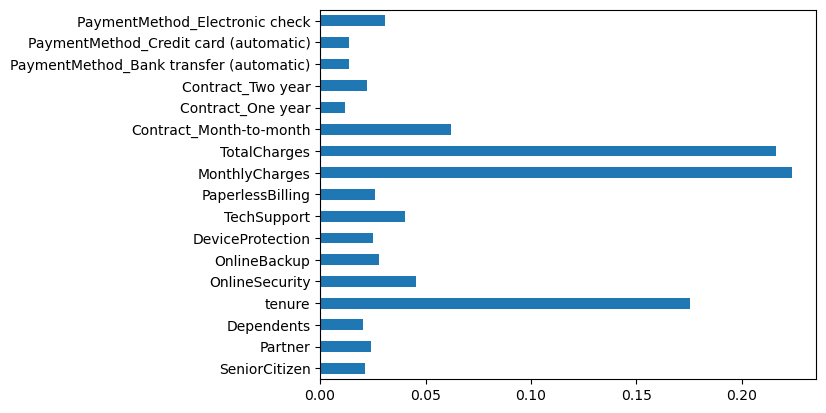

In [149]:
from sklearn.ensemble import RandomForestClassifier

## 特征提取和标签分离
X = df.drop(columns=["Churn"])
Y = df["Churn"]

model = RandomForestClassifier()
model.fit(X, Y)
importance = pd.Series(model.feature_importances_, index=X.columns)
importance.plot(kind="barh")
plt.show()

# 模型选择与训练
## Q1 问题 (监督学习)
### 逻辑回归（基线模型）

In [150]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

## 数据集划分
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## 模型训练
# 解决收敛警告：增加最大迭代次数
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(y_pred)


[1 0 0 ... 0 0 0]


### 决策树

In [151]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth=3)
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)

print(y_pred)

[1 0 0 ... 0 0 1]


## Q2 问题 （无监督学习）
### K-Means

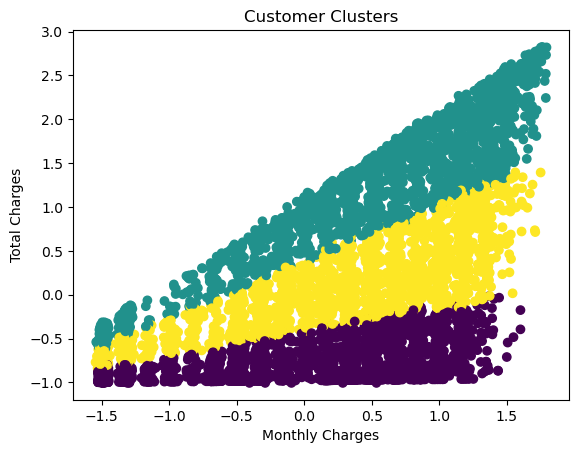

In [152]:
from sklearn.cluster import KMeans

# 基于特征聚类（去除标签"Churn"）
kmeans = KMeans(n_clusters=3)
df["Cluster"] = kmeans.fit_predict(df.drop("Churn", axis=1))

# 可视化聚类结果
plt.scatter(df["MonthlyCharges"], df["TotalCharges"], c=df["Cluster"], cmap="viridis")
plt.xlabel("Monthly Charges")
plt.ylabel("Total Charges")
plt.title("Customer Clusters")
plt.show()

# 模型评估

## Q1
### 核心指标：召回率（Recall）优先（流失客户需重点识别）

In [153]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1036
           1       0.68      0.60      0.64       373

    accuracy                           0.82      1409
   macro avg       0.77      0.75      0.76      1409
weighted avg       0.81      0.82      0.81      1409

ROC AUC: 0.861982050990094



### 主要模型评估指标

#### 1. 准确率 (Accuracy)
**定义**: 预测正确的样本数占总样本数的比例
**公式**: Accuracy = (TP + TN) / (TP + TN + FP + FN)
**结果**: 0.82 (82%)

**含义**: 整体预测准确性，但在不平衡数据集中可能有误导性

##### 2. 精确率 (Precision)
**定义**: 在所有预测为正例的样本中，真正为正例的比例
**公式**: Precision = TP / (TP + FP)
**结果**: 
- 非流失客户 (0): 0.86
- 流失客户 (1): 0.68

**含义**: 预测为流失的客户中，真正流失的比例

#### 3. 召回率 (Recall)
**定义**: 在所有真正的正例中，被正确预测为正例的比例
**公式**: Recall = TP / (TP + FN)
**结果**:
- 非流失客户 (0): 0.90
- 流失客户 (1): 0.60

**含义**: 所有真正流失的客户中，被成功识别的比例

#### 4. F1分数 (F1-score)
**定义**: 精确率和召回率的调和平均数
**公式**: F1 = 2 × (Precision × Recall) / (Precision + Recall)
**结果**:
- 非流失客户 (0): 0.88
- 流失客户 (1): 0.64

**含义**: 在精确率和召回率之间寻求平衡

#### 5. ROC AUC
**定义**: ROC曲线下的面积，衡量模型区分正负样本的能力
**取值范围**: 0-1，0.5表示随机猜测，1表示完美分类
**结果**: 0.862

**含义**: 模型整体性能很好，能够较好地区分流失和非流失客户

#### 客户流失预测中的评估策略

#### 业务场景分析
在您的电信客户流失预测场景中：

1. **召回率优先**: 正如您在笔记中提到的，需要重点识别流失客户
   - 错过一个流失客户的成本 > 误判一个非流失客户的成本
   - 当前召回率 0.60 意味着40%的流失客户被漏掉了

2. **精确率权衡**: 精确率 0.68 表示预测流失的客户中有32%是误判
   - 需要在营销成本和覆盖面之间权衡

## Q2
### 分析聚类结果与流失率的关系

In [154]:
print(df.groupby("Cluster")["Churn"].mean())

Cluster
0    0.434677
1    0.095132
2    0.210280
Name: Churn, dtype: float64


| 模型 | 监督学习（逻辑回归） | 监督学习（决策树） | 无监督学习（K-Means） |
|------|----------------------|--------------------|-----------------------|
| **目标** | 预测流失概率 | 解释流失规则 | 发现潜在客户分群 |
| **优势** | 计算高效 | 可视化决策路径 | 无需标注数据 |
| **劣势** | 假设线性关系 | 易过拟合 | 结果需人工解读 |